In [3]:
#Library imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from datetime import datetime, timedelta, date
import time


In [4]:
# #Import local database interface 

import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from helpers.db_query import queryDB 



In [53]:
# #Wrapper function for the database interface

# def queryDB(query, labels):
#     db = MySQLConnector()
#     out = db.execute(query)
#     db.close()
#     return pd.DataFrame.from_records(out, columns=labels)



## Preprocessing

In [5]:
#Constants
COURSES_ID = "('EPFL-AlgebreLineaire-2017_T3', 'EPFL-AlgebreLineaire-2018')"
StudentID = 'AccountUserID'
Year = 'Year'
year1 = '2017'
year2= '2018'
Source = 'VideoID'

In [6]:
columns = ["AccountUserID", "DataPackageID","VideoID", "TimeStamp", "EventType", "SeekType", 
             "OldTime", "CurrentTime", "NewTime", "OldSpeed", "NewSpeed"]
query ="""
SELECT {}
FROM ca_courseware.Video_Events
WHERE DataPackageID in {}
""".format(", ".join(columns), COURSES_ID)
df = queryDB(query, columns)


### Create year column

In [8]:
def addYearColumn(df):
    df[Year] = df['DataPackageID'].apply(lambda x: year1 if('2017' in x) else year2)
    return df

In [9]:
addYearColumn(df)
df.head()


,AccountUserID,DataPackageID,VideoID,TimeStamp,EventType,SeekType,OldTime,CurrentTime,NewTime,OldSpeed,NewSpeed,Year
0,9893,EPFL-AlgebreLineaire-2017_T3,4d31551afe0e437e9efb0de334c8267c,1509555123,Video.Play,None,NaN,184.694,NaN,NaN,NaN,2017
1,9914,EPFL-AlgebreLineaire-2017_T3,a48d8f0bbac04689a88f8b06cf53154e,1508769890,Video.Play,None,NaN,603.000,NaN,NaN,NaN,2017
2,12494,EPFL-AlgebreLineaire-2017_T3,7ad7b082ef9149f280e3d7b9be2aa348,1510329102,Video.Play,None,NaN,202.526,NaN,NaN,NaN,2017
3,9923,EPFL-AlgebreLineaire-2017_T3,cea9957b2f57401bbb75e15230dfaadc,1510682346,Video.Play,None,NaN,613.206,NaN,NaN,NaN,2017
4,10787,EPFL-AlgebreLineaire-2017_T3,8298affd57ae43d6a46c3c2a60777fba,1510647821,Video.Stop,None,NaN,706.342,NaN,NaN,NaN,2017


### Events

Create more events (speed down vs speed up , seek back vs seek forward etc.) and drop events which we dont really need (transcript translation etc.)

In [7]:
def drop_and_relabel(df): 
    X = df.copy()
    
    # lets relabel seek events into either seek back or seek forward    
    X.loc[X["OldTime"] > X["NewTime"], "EventType"]  = "Video.SeekBack"
    X.loc[X["OldTime"] < X["NewTime"], "EventType"]  = "Video.SeekForward"
    X = X.loc[X["EventType"] != "Video.Seek"]
    
    # lets relabel speed change into speedup or speed down
    X.loc[X["OldSpeed"] < X["NewSpeed"], "EventType"]  = "Video.SpeedUp"
    X.loc[X["OldSpeed"] > X["NewSpeed"], "EventType"]  = "Video.SpeedDown"
    X = X.loc[X["EventType"] != "Video.SpeedChange"]
    
    # drop unnecessary events
    X = X[X['EventType'] != 'Video.Transcript.Translate.EN']
    X = X[X['EventType'] != 'Video.Transcript.Download']
    X = X[X['EventType'] != 'Video.Transcript.Hide']
    X = X[X['EventType'] != 'Video.Transcript.Show']
    
    return X

### Drop outliers

Drop students who have repeated the course - we consider them outliers as they have engaged with the content once already and watched videos at irregular periods.

In [8]:
# remove repeating students
def remove_repeat(df):
    retook_students = []
    for s in set(df[StudentID]):
        x = df[df[StudentID] == s]
        y1 = len(x[x[Year] == year1]) > 0
        y2 = len(x[x[Year] == year2]) > 0
        if y1 and y2:
            retook_students.append(s)

    X = df.copy() 
    for s in retook_students:
        mask = (X[StudentID] == s) & (X[Year] == year2)
        X = X[~mask]
    
    return X

### Minimum activity

Filter students out who have lesser than 60 videos to their names. The student who watched the most videos in our dataset has 139 videos, we try to get the other students to have at least half of this. This means they have engaged with the MOOC platforms and we have something to analyse.

In [9]:
# filter out students with less than 60 videos
def students_with_activity(df):
    vid_df = df[[StudentID, Source]].drop_duplicates()
    vid_cnt = vid_df.groupby(StudentID).count().reset_index().rename(columns={Source: 'Count'})
    vid_cnt = vid_cnt[vid_cnt['Count'] > 60]
    return pd.merge(left=vid_cnt, right=df, on=StudentID).drop_duplicates()

### Pipeline

In [10]:
def preprocess(df):
    X = drop_and_relabel(df)
    X = remove_repeat(X)
    X = students_with_activity(X)
    return X

In [20]:
df_clean = preprocess(df)

## Regularity
**Q**: How does a student's regularity with the MOOC course affect his final grade?


### How can we measure regularity?
<p>In order to measure regularity, we turn to existing research, namely the paper <a href="https://link.springer.com/chapter/10.1007/978-3-319-45153-4_21">"How to quantify regularity" by Sharma et al in EPFL CHILI lab</a>. The paper derives different measures for regularities and explains their properties. We will be looking at the same properties (albeit with slight modifications).</p>
<p>The measures include:</p>
<table>
<thead><tr>
<th style="text-align:center">Measure</th>
<th style="text-align:center">Description</th>
<th style="text-align:center">Justification</th>
</tr>
</thead>
<tbody>
<tr>
<td style="text-align:center">PDH</td>
<td style="text-align:center">Peak on day hour</td>
<td style="text-align:center">Identifies if a student's activities are centred around a particular hour of the day</td>
</tr>
<tr>
<td style="text-align:center">PWD</td>
<td style="text-align:center">Peak on week day</td>
<td style="text-align:center">Identifies if a student's activities are centred around a particular day of the week</td>
</tr>
<tr>
<td style="text-align:center">WS1</td>
<td style="text-align:center">Weekly Similarities in daily activity</td>
<td style="text-align:center">Identifies if student works on same weekdays</td>
</tr>
    <tr>
<td style="text-align:center">WS2</td>
<td style="text-align:center">Weekly Similarities in daily activity</td>
<td style="text-align:center">Identifies if there is a similar distribution of workload among weekdays</td>
</tr>
<tr>
<td style="text-align:center">WS3</td>
<td style="text-align:center">Weekly Similarities in daily activity</td>
<td style="text-align:center">Identifies if there is a similar time repartition of workload among weekdays</td>
</tr>
<tr>
<td style="text-align:center">FDH</td>
<td style="text-align:center">Hourly Pattern over days</td>
<td style="text-align:center">Identifies if hourly pattern is repeating over days</td>
</tr>
<tr>
<td style="text-align:center">FWH</td>
<td style="text-align:center">Hourly Pattern over weeks</td>
<td style="text-align:center">Identifies if hourly pattern is repeating over weeks</td>
</tr>
<tr>
<td style="text-align:center">FWD</td>
<td style="text-align:center">Daily Pattern over Weeks</td>
<td style="text-align:center">Identifies if daily pattern is repeating over weeks</td>
</tr>
</tbody>
</table>



### Metadata

In [11]:

MOOC = {
    '2017':{
        'Start': '2017-10-16', # Start of the flipped period
        'Start_ts': time.mktime(date(2017, 10, 16).timetuple()),
        'End_ts': None, # Dynamically defined  later in the notebook
        'End':  '2018-01-28',
        'Exam': '2018-01-22',
        'Weekly_video_count': [2,3,2,2,4,3,2,3,3,1,2,2,2,3], #number of videos per week in the semester
        'Flipped_weeks': 5, #Number of weeks during which the class was flipped
        'Total_quiz': None # Total nuber of quiz in the flipped period, dynamically defined  later in the notebook

    },
    '2018':{
        'Start': '2018-10-16',
        'Start_ts': time.mktime(date(2018, 10, 16).timetuple()),
        'End': '2019-01-28',
        'Exam': '2019-01-21',
        'Flipped_weeks': 10 
    }
}

### Helper functions

In [14]:

#Timestamp to datetime object
def convert_to_date(ts):
    return datetime.fromtimestamp(ts)

def normalize(v):
    s = v.sum()
    if s == 0: return v
    return v / s

def get_rand_id(X):
    studentID =  list(X[StudentID].sample(1))[0]
    print("Random ID: {}".format(studentID))
    return studentID

def get_rand_student(X, studentID): # /!\ studentID != StudentID
    if(not studentID):
        studentID = get_rand_id(X)
    return X[X[StudentID] == str(studentID)]

# def get_student_by_id(X,student_id):
#     return X[X[StudentID] == student_id]

#Get the list of timestamps indicating when the student was active 
#Student is a table containing all the rows of `student`
def get_time(student):
    year = list(student[Year])[0]
    T = student['TimeStamp'].sort_values()
    T = T - MOOC[year]['Start_ts']
    T = np.where(T < 0, 0, T)
    return list(T), MOOC[year]['Flipped_weeks']



### Peaks in Hourly/Daily Activity (PDH/PWD)

Here are the functions and Regularity paper's expressions equivalence table:

| Code | Expression |
| --- | --- | 
| `student_activity` | $F_W(x)$ |
| `activity_at_hour` | $D(h)$ |
| `activity_at_day` | $W(d)$ |
| `entropy` | $E_D$ or $E_W$ |




In [17]:
from scipy.special import entr #entropy

def student_activity(W, T, x):
    T = np.floor_divide(T, W)
    return int(x in T)

def daily_activity(Ld, T):
    def activity_at_hour(h):
        res = 0
        for i in range(Ld):
            res += student_activity(60*60, T, 24*i + h)
        return res
    hist = list(range(24))
    return list(map(activity_at_hour, hist))

def weekly_activity(Lw, T):
    def activity_at_day(d):
        res = 0
        for i in range(Lw):
            res += student_activity(24*60*60, T, 7*i + d)
        return res
    hist = list(range(7))
    return list(map(activity_at_day, hist))

def PDH(Lw, T):
    activity = np.array(daily_activity(Lw * 7, T))
    normalized_activity = normalize(activity)
    entropy = entr(normalized_activity).sum()
    return (np.log2(24) - entropy) * np.max(activity)

def PWD(Lw, T):
    activity = np.array(weekly_activity(Lw, T))
    normalized_activity = normalize(activity)
    entropy = entr(normalized_activity).sum()
    return (np.log2(7) - entropy) * np.max(activity)




In [18]:
def plotHourlyActivity(X, studentID = 0):
    student = get_rand_student(X, studentID)
    T, Lw = get_time(student)
    PDHs = "{:.2f}".format(PDH(Lw, T))

    plt.bar(np.arange(1, 25), daily_activity(Lw*7, T))
#     plt.ylim(0,10)
    plt.title("Student Activity per Hour, PDH = " + PDHs) #+ " Grade = " + str(grade))
    plt.xlabel("Hour")
    plt.ylabel("PDH")
    
def plotWeeklyActivity(X, studentID = 0):
    student = get_rand_student(X, studentID)
    T, Lw = get_time(student)
    PWDs = "{:.2f}".format(PWD(Lw, T))
    
    plt.bar(np.arange(1, 8), weekly_activity(Lw, T))
    plt.ylim(0,10)
    plt.title("Student Activity per Week, PWD = " + PWDs ) #+ " Grade = " + str(grade))
    plt.xlabel("Day of the week")
    plt.ylabel("PDH")

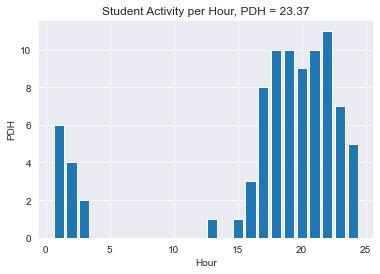

In [21]:
plotHourlyActivity(df_clean,11609)
# 12689 2.02
# 9728 8
# 11609 20.6
# 12887 30

In [22]:
# T = np.arange(24) * 3600
Lw = 10
T = np.arange(Lw) * 3600 * 24 * 7
print(PWD(Lw, T),np.log2(7) * Lw)

28.07354922057604 28.07354922057604


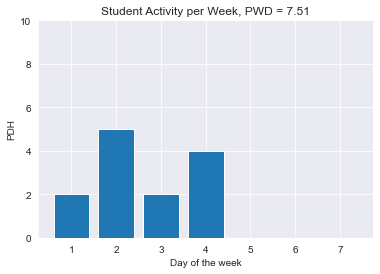

In [23]:
plotWeeklyActivity(df_clean, 9749 )
# 9950 2
#9749 7.5

### Weekly similarities (WS1/WS2/WS3)

**WS1:** Measures how much the student works on the same weekdays

**WS2:** Measures if there is a similar distribution of workload among weekdays

**WS3:** Measures if there is a similar time spent working among weekdays. WS3 also depends on the absolute time while WS2 only depends on the distribution.


In [99]:
from scipy.spatial.distance import jensenshannon

# global constants
HOUR_TO_SECOND = 60 * 60
DAY_TO_SECOND = 24 * HOUR_TO_SECOND
WEEK_TO_SECOND = 7 * DAY_TO_SECOND

def similarity_days(wi, wj):
    m1 = np.where(wi == 1)[0]
    m2 = np.where(wj == 1)[0]
    if len(m1) == 0 or len(m2) == 0: 
        return 0
    
    return len(np.intersect1d(m1, m2)) / max(len(m1), len(m2))

def aggregate_activity(W, T, Ls):
    res = []
    for x_i in range(Ls // W):
        res.append(student_activity(W, T, x_i))
    return np.array(res)

def days_active(Lw, T):    
    X = aggregate_activity(DAY_TO_SECOND, T, Lw * WEEK_TO_SECOND)
    X = X.reshape([Lw, 7])
    return X

def activityProfile(Lw, T):
    activity = []
    X = np.array(aggregate_activity(HOUR_TO_SECOND, T, Lw * WEEK_TO_SECOND))
    X = X.reshape([Lw, 7*24])
    for week in X:
        week = week.reshape([7, 24])
        activity.append(week.sum(axis=1))
    return activity

def chi2_divergence(p1, p2, a1, a2):
    a = p1 - p2
    b = p1 + p2
    frac = np.divide(a, b, out=np.zeros(a.shape, dtype=float), where=b!=0)
    m1 = np.where(a1 == 1)[0]
    m2 = np.where(a2 == 1)[0]
    union = np.union1d(m1, m2)
    if (len(union) == 0): return np.nan
    return 1 - (1 / len(union)) * np.sum(np.square(frac))

def WS1(Lw, T):
    hist = days_active(Lw, T)
    res = []
    for i in range(Lw):
        for j in range(i + 1, Lw):
            res.append(similarity_days(hist[i], hist[j]))
    res = np.clip(np.nan_to_num(res), 0, 1) #Bound values between 0 and 1
    return np.mean(res)

def WS2(Lw, T):
    profile = activityProfile(Lw, T)
    res = []
    for i in range(Lw):
        for j in range(i + 1, Lw):
            if not profile[i].any() or not profile[j].any(): continue
            res.append(1 - jensenshannon(profile[i], profile[j], 2.0))
    if len(res) == 0: return np.nan
    res = np.clip(np.nan_to_num(res), 0, 1) #Bound values between 0 and 1
    return np.mean(res)
    
def WS3(Lw, T):
    profile = activityProfile(Lw, T)
    hist = days_active(Lw, T)
    res = []
    for i in range(Lw):
        for j in range(i + 1, Lw):
            if not profile[i].any() or not profile[j].any(): continue
            res.append(chi2_divergence(profile[i], profile[j], hist[i], hist[j]))
    if len(res) == 0: return np.nan
    res = np.clip(np.nan_to_num(res), 0, 1) #Bound values between 0 and 1
    return np.mean(res)


In [25]:

def day_activity_by_week(Lw, T):
    def activity_at_day(w,d):
        res = 0
        for h in range(24):
            res += student_activity(60*60, T, w*7*24 + d*24 + h)
        return res
    days = np.zeros((Lw, 7))
    for w in range(Lw):
        for d in range(7):
             days[w,d] = activity_at_day(w,d)
    return days

def plotWS(X, studentID=0):
    student = get_rand_student(X, studentID)
    T, Lw = get_time(student)
    WS = "{:.2f}, {:.2f}, {:.2f}".format(WS1(Lw, T), WS2(Lw, T), WS3(Lw, T))
    ax = sns.heatmap(day_activity_by_week(Lw, T), cmap=sns.cubehelix_palette(as_cmap=True))
    ax.invert_yaxis()
    plt.title("Weekly similarities with (WS1, WS2, WS3) = (" + WS+")") 
    plt.ylabel('Week')
    plt.xlabel('Day')


Random ID: 51969
[0.5, 0.5, 0.8796296296296297, 0.28888888888888875, 0.8796296296296297, 0.5697222222222222, 0.43518518518518523, 0.24489795918367352, 0.2962962962962963, 1.0, 0.6533333333333333, 0.1875, 0.5833333333333334, 0.4948979591836735, 0.96875, 0.5925925925925926, 0.48, 0.6533333333333333, 0.1875, 0.5833333333333334, 0.4948979591836735, 0.96875, 0.5925925925925926, 0.48, 0.34104308390022675, 0.8662962962962963, 0.7071201814058956, 0.6325000000000001, 0.4097222222222222, 0.32000000000000006, 0.3155, 0.5874999999999999, 0.1875, 0.16528925619834722, 0.0, 0.5700000000000001, 0.5185185185185186, 0.34467120181405897, 0.2962962962962963, 0.49691358024691357, 0.36977777777777776, 0.2222222222222222, 0.6268748086929905, 0.40816326530612246, 0.25]


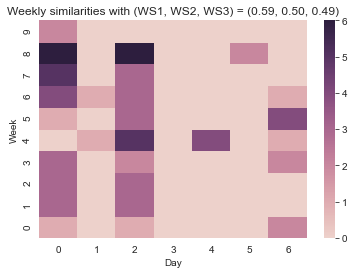

In [65]:
plotWS(df_clean, 10157)
# 47712 all on sundays
# 10118 all at the beginning of the week
# 49212 a session of 10 hours
# 46461 all on weekend

### Frequency patterns (FDH/FWH/FWD)

The Fourier analysis measures if there is any periodicity in the time spent watching the videos.

**FDH:** Hourly pattern over the day.

**FWH:** Hourly pattern over the week.

**FWD:** Daily pattern over the week.

In [27]:
def fourierTransform(Xi, f, n):
    M = np.exp(-2j * np.pi * f * n)
    return np.dot(M, Xi)

def FDH(Lw, T, f = 1/24):
    Xi = aggregate_activity(HOUR_TO_SECOND, T, Lw * WEEK_TO_SECOND)
    n = np.arange(Lw * WEEK_TO_SECOND // HOUR_TO_SECOND)
    return abs(fourierTransform(Xi, f, n))

def FWH(Lw, T, f= 1/(7*24)):
    Xi = aggregate_activity(HOUR_TO_SECOND, T, Lw * WEEK_TO_SECOND)
    n = np.arange(Lw * WEEK_TO_SECOND // HOUR_TO_SECOND)
    return abs(fourierTransform(Xi, f, n))

def FWD(Lw, T, f = 1/7):
    Xi = aggregate_activity(DAY_TO_SECOND, T, Lw * WEEK_TO_SECOND)
    n = np.arange(Lw * WEEK_TO_SECOND // DAY_TO_SECOND)
    return abs(fourierTransform(Xi, f, n))

In [28]:
def plotFourier(X, studentID=0):
    student = get_rand_student(X, studentID)
    T, Lw = get_time(student)
    FWD_value = FWD(Lw, T)
    fourier_values = "{:.2f}, {:.2f}, {:.2f}".format(FDH(Lw, T), FWH(Lw, T),FWD_value)
    print("FDH, FWH, FWD = "+fourier_values)
    

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))
    
    activity = aggregate_activity(DAY_TO_SECOND, T, Lw * WEEK_TO_SECOND)
    days = np.arange(len(activity))
    line1 = sns.lineplot(ax = axes[0], x = np.arange(len(activity)), y = activity)
    for week in range(7, days[-1], 7):
        if week == 7:
            axes[0].axvline(x=week, c='gray', ls='--', label="Weeks")
        else:
            axes[0].axvline(x=week, c='gray', ls='--')
    line1.set_title("Student activity over the days") 
    line1.set_ylabel('Active or not')
    line1.set_xlabel('Day')
    axes[0].legend()
    
    freq = np.arange(0.1,0.5,1/70) # step is a multiple of 1/7, the weekly frequency
    spectrum = [FWD(Lw, T, f) for f in freq]
    line2 = sns.lineplot(ax = axes[1], x = freq, y = spectrum)
    axes[1].axvline(x=1/7, label="1 / 7",c='red', ls='--') 
    line2.set_ylim(0, 15)
    line2.set_title("Spectrum with FWD = {:.2f}".format(FWD_value)) 
    line2.set_ylabel('Spectrum')
    line2.set_xlabel('Frequency')
    axes[1].legend()
    


FDH, FWH, FWD = 38.86, 45.33, 13.09


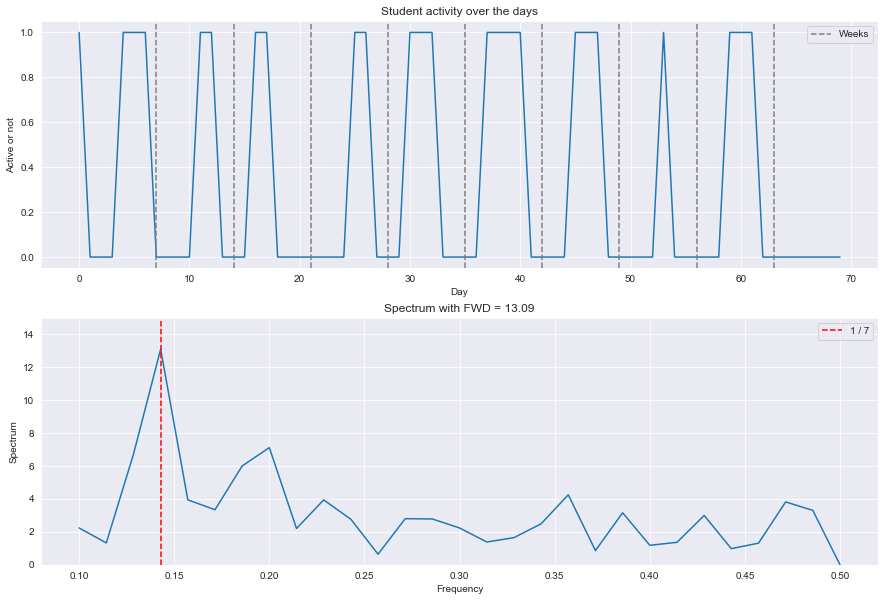

In [29]:
plotFourier(df_clean,44790)
# 44790 13
# 11609 4.71

### Quizzes

Let's first count how many quizzes students complete and then an interesting insight would be to analyze features related to when they complete them.

In [10]:
columns = ["AccountUserID", "DataPackageID","ProblemID", "TimeStamp", "EventType", "ProblemType"]

# Selecting rows with unique (AccountUserID, ProblemID) pair
# Foreach AccountUserId, the subquery assignes an incrementing row number rn for each ProblemId
# And the top query only keeps the first one, i.e rn = 1, which is the first event that occured chronologically
query = """
SELECT {columns}
FROM (
    SELECT {columns}, ROW_NUMBER() OVER(PARTITION BY AccountUserID, ProblemID 
                                        ORDER BY AccountUserID, ProblemID, TimeStamp) rn
    FROM ca_courseware.Problem_Events_with_Info
    WHERE DataPackageID in {courses}) t
WHERE rn = 1;
""".format(columns=", ".join(columns), courses=COURSES_ID)
quiz_df = addYearColumn(queryDB(query, columns))

In [11]:
quiz_df.head()

,AccountUserID,DataPackageID,ProblemID,TimeStamp,EventType,ProblemType,Year
0,10007,EPFL-AlgebreLineaire-2017_T3,05da88dd254448ffbcd71948d238e620,1510230324,Problem.Check,Quiz,2017
1,10007,EPFL-AlgebreLineaire-2017_T3,079510d3d45649b0a2e4c8e583bd6d89,1508962827,Problem.Check,Quiz,2017
2,10007,EPFL-AlgebreLineaire-2017_T3,095186b3538a456aa00261731e4e03f6,1508959141,Problem.Check,Quiz,2017
3,10007,EPFL-AlgebreLineaire-2017_T3,0aa69a7cb9bd4d729ae369cf3431bcd5,1508961153,Problem.Check,Quiz,2017
4,10007,EPFL-AlgebreLineaire-2017_T3,0e9e93d7015b4a8bbcb0ce35b3f1fc43,1510173429,Problem.Check,Quiz,2017


#### Quiz completion


| Measure | Meaning | Description |
| --- | --- | --- | 
| NQZ | Number of quiz |Counts the total number of quiz completed by a student over the semester |
| PQZ | Percentage of quiz | Counts the percentage of quiz completed by a student over the flipped period|

##### NQZ

The NQZ feature counts the total number of quiz completed by a student. An issue with this feature is that it takes into account quizzes outside of the flipped period. A better solution would be to assign the percentage of quiz completed (from the flipped period), therefore normalizing the feature at the same time.

In [15]:
def NQZ(studentID = 0):
    if studentID == 0:
        studentID = get_rand_id(quiz_df)
    return quiz_df[["AccountUserID","ProblemID"]].groupby("AccountUserID").count().loc[str(studentID)][0]

In [16]:
print("Total number of quiz completed (NQZ) is {}".format(NQZ()))

Random ID: 8289
Total number of quiz completed (NQZ) is 236


##### PQZ 

Define the attributes `End_ts` and `Total_quiz` of the `MOOC` dict 

In [24]:
import json
with open('../config/linear_algebra.json') as f:
        MOOC = json.load(f)

In [25]:
# Total number of quizzes included in the flipped period
# We assume that every quizzes in the flipped period have been completed 
# at least once by a student during the flipped period
for year in ['2017', '2018']:
    
    #Compute the end timestamp of the flipped period
    start_flipped = MOOC[year]['Start_ts']
    end_flipped = start_flipped + timedelta(weeks=MOOC[year]['Flipped_weeks']).total_seconds()
    MOOC[year]['End_ts'] = end_flipped
    
    query = """
        SELECT COUNT(DISTINCT ProblemID)
        FROM ca_courseware.Problem_Events_with_Info
        WHERE DataPackageID in {courses}
        AND TimeStamp > {start} 
        AND TimeStamp < {end}
    """.format(courses=COURSES_ID, start= start_flipped, end = end_flipped)
    MOOC[year]['Total_quiz'] = queryDB(query, ["NbProblems"]).loc[0]['NbProblems']

KeyError: 'Start_ts'

In [22]:
def PQZ(studentID = 0):
    if studentID == 0:
        studentID = get_rand_id(quiz_df)
    temp = list(quiz_df.groupby(by=["AccountUserID", "Year"]).count()\
                .loc[str(studentID)].reset_index().iloc[0])
    count = temp[1]
    year = temp[0]
    return  count / MOOC[year]['Total_quiz'], count, MOOC[year]['Total_quiz']

In [23]:
pqz = PQZ()
print("""Proportion of quiz completed (PQZ) is {:.2f}
with {} quizzes completed over {}.""".format( pqz[0], pqz[1], pqz[2]))

Random ID: 10460


KeyError: 'Total_quiz'

#### Quiz timings

| Measure | Meaning | Description |
| --- | --- | --- | 
| IVQ | Interval between Video and Quiz  | Std of time interval between a quiz completion and the corresponding video viewing |
| SRQ | Semester Repartition of the Quizzes | Repartition of the quiz completions over the semester |

Current issues:
* IVQ: 
    * [x] Consider only the flipped period 
    * [x] Need to have to chapter of each video and quiz
    * [x] Consider only the first video viewing and first quiz completion
    * [ ] Analyze the time series

* SRQ:
    * [x] Consider only the flipped period
    * [x] Consider only the first completion of each quiz
    * [ ] Analyze the repartition


In [26]:
PATH_DATED = '../data/lin_alg_moodle/'
PATH_DATED_VIDEOS = PATH_DATED + 'videos.csv'
PATH_DATED_PROBLEMS = PATH_DATED + 'problems.csv'

dated_videos_df = pd.read_csv(PATH_DATED_VIDEOS, index_col=0)
dated_problems_df = pd.read_csv(PATH_DATED_PROBLEMS, index_col=0)

##### IVQ - Interval between Video and Quiz

In [27]:
def getFirstViewings(studentID):
    """
    Filter the video events so that the returned dataframe only contains
    the first play event of each different videos viewed by the student with id studentID.
    """
    return df.loc[(df[StudentID] == str(studentID)) & (df.EventType == "Video.Play")]\
            .sort_values(by="TimeStamp").drop_duplicates(subset=["VideoID"], keep="first")\
            [["AccountUserID", "VideoID", "Year", "TimeStamp"]]

def getFirstCompletions(studentID):
    """
    Filter the problem (=quiz) events so that the returned dataframe only contains
    the first completion of each different quizzes done by studentID
    """
    return quiz_df.loc[(quiz_df[StudentID] == str(studentID)) & (quiz_df.EventType == "Problem.Check")]\
            .sort_values(by="TimeStamp").drop_duplicates(subset=["ProblemID"], keep="first")\
            [["ProblemID", "TimeStamp"]]

def mergeOnSubchapter(viewing_df, completion_df):
    """
    Merge the video viewings with the quiz completion for a student.
    """
    # Join on VideoID
    return viewing_df.merge(dated_videos_df[["VideoID", "Subchapter"]])\
            .merge(dated_problems_df[["ProblemID", "Subchapter"]])\
            .rename(columns={"TimeStamp":"TimeStamp_Video"})\
            .merge(completion_df)\
            .rename(columns={"TimeStamp":"TimeStamp_Quiz"})

def IQR(data):
    """
    Compute the Inter-Quartile Range of an array, that is, the difference between 
    the third quantile and the first quantile. Thus half the values 
    are located in this range.
    """
    q3, q1 = np.percentile(data, [75 ,25])
    iqr = q3 - q1
    return iqr

def IVQ(studentID = 0):
    """
    For every completed quiz, compute the time intervals (minutes)
    between the first viewing of the video and the quiz completion
    and return the interquartile range of the time intervals
    """
    if studentID == 0:
        studentID = get_rand_id(quiz_df)
    merged_df = mergeOnSubchapter(getFirstViewings(studentID), getFirstCompletions(studentID))
    time_intervals = np.array(merged_df.TimeStamp_Quiz - merged_df.TimeStamp_Video)
    time_intervals = np.log(time_intervals[time_intervals > 0]) #Only keep positive intervals and convert to minutes
    return IQR(time_intervals), time_intervals


In [28]:
def plot_IVQ(studentID = 0):
    ivq, time_intervals = IVQ(studentID)
    title = """Time intervals with an inter-quartile range of {:.3f} minutes
    with {} intervals
    """.format(ivq, len(time_intervals))
    sns.boxplot(data=time_intervals)
    plt.title(title)
    plt.ylabel("Time intervals in minutes")

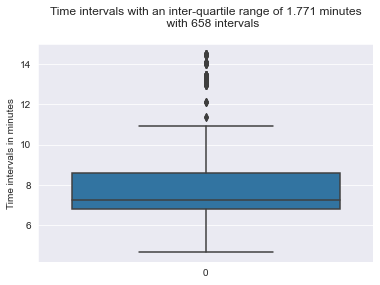

In [29]:
plot_IVQ(46497)
#46497

In [30]:
ivq, time_intervals = IVQ(46497)
time_intervals.sort()
pd.DataFrame(time_intervals).describe()

,0
count,308.000000
mean,1016.063366
std,4115.984221
min,1.783333
25%,13.916667
50%,20.850000
75%,46.816667
max,32770.916667


##### SRQ - Semester Repartition of the Quizzes

In [31]:
def SRQ(studentID = 0):
    """
    Measures the repartition of the quiz completions. The std (in hours) of the time intervals is computed
    aswell as the dates of completions. The smaller the std is, the more regular the student is.
    """
    if studentID == 0:
        studentID = get_rand_id(quiz_df)
    completion_df = getFirstCompletions(studentID)
    completion_df["Day"] = completion_df.TimeStamp.apply(lambda x: convert_to_date(x))
    return np.diff(completion_df.TimeStamp.values).std() / 3600, completion_df.Day


In [32]:
def plot_SRQ(studentID = 0):
    if studentID == 0:
        studentID = get_rand_id(quiz_df)
    year = quiz_df.loc[quiz_df.AccountUserID == str(studentID)].Year.iloc[0]
    plt.figure(figsize=(15,5)) 
    srq, dates = SRQ(studentID)
    sns.histplot(data=dates, bins=len(dates))
    plt.title("First quiz completions with SRQ = {:.2f} hours".format(srq))
    start_date, end_date = convert_to_date(MOOC[year]['Start_ts']), convert_to_date(MOOC[year]['End_ts'])
    plt.xlim((start_date, end_date))
    

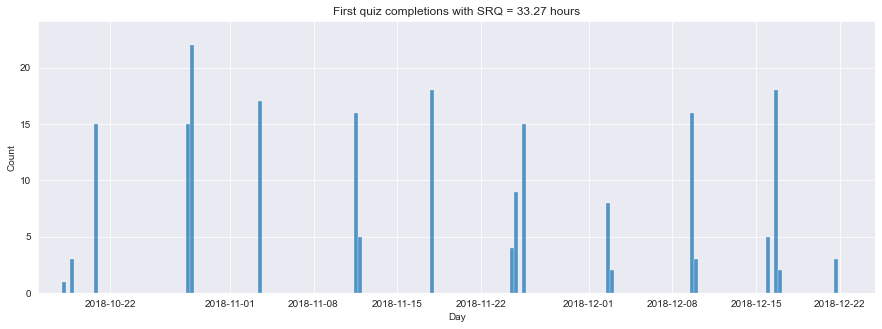

In [33]:
studentID = 12275
plot_SRQ(studentID)
# 47274 early completion
# 12275 evenly spread
# 10007 2017 example
# 46776 30 hours
# 47385 56 hours

## Wrapper function

In [71]:
def compute_feature(feat_func, df, sid = 0):
    sid = str(list(df['AccountUserID'].sample(1))[0] if not sid else str(sid))
    sdata = df[df['AccountUserID'] == str(sid)]
    T = sdata['TimeStamp'].sort_values() - sdata['TimeStamp'].min() #Make timestamps start from 0
    # Compute the length (in weeks) of the period covered by the df 
    # by converting the max timestamp to week since the first timestamp is 0
    Lw = T.max() // (3600 * 24 * 7) + 1 
    return feat_func(Lw, T) #Compute the feature given in argument

In [45]:
wrapper_df = df.loc[(df.TimeStamp > 1509555123) & (df.TimeStamp < 1509555123 + 11 * (3600 * 24 * 7))]

In [98]:
features = [PDH, PWD, FDH, FWH, FWD, WS1, WS2, WS3]
for feat in features:
    print(feat.__name__, compute_feature(feat, df, 10157))

PDH 32.87657806053738
PWD 4.387446768010402
FDH 5.940730937535035
FWH 7.412258444977648
FWD 4.7322015618826185
WS1 0.0019305019305019305
WS2 0.22012237992683853
WS3 0.003141778141778142


In [93]:
compute_feature(WS3, df, 10157)

0.003141778141778142

In [83]:
a = [1,2, np.nan, 4]

np.nan_to_num(a)

array([1., 2., 0., 4.])

In [33]:
df.loc[df.AccountUserID == "9893"].sort_values(by="TimeStamp")

,AccountUserID,DataPackageID,VideoID,TimeStamp,EventType,SeekType,OldTime,CurrentTime,NewTime,OldSpeed,NewSpeed,Year
58628,9893,EPFL-AlgebreLineaire-2017_T3,07df6f849eee47659a13908de0732387,1505394049,Video.Transcript.Translate.EN,None,NaN,NaN,NaN,NaN,NaN,2017
48666,9893,EPFL-AlgebreLineaire-2017_T3,07df6f849eee47659a13908de0732387,1505394049,Video.Load,None,NaN,NaN,NaN,NaN,NaN,2017
121159,9893,EPFL-AlgebreLineaire-2017_T3,22c2895963d24114b16c3511befa35d6,1505394600,Video.Load,None,NaN,NaN,NaN,NaN,NaN,2017
111561,9893,EPFL-AlgebreLineaire-2017_T3,22c2895963d24114b16c3511befa35d6,1505394600,Video.Transcript.Translate.EN,None,NaN,NaN,NaN,NaN,NaN,2017
84212,9893,EPFL-AlgebreLineaire-2017_T3,22c2895963d24114b16c3511befa35d6,1505394613,Video.Play,None,NaN,0.003,NaN,NaN,NaN,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
77516,9893,EPFL-AlgebreLineaire-2017_T3,b8826493ef8c4aaf8dbc6e8380d7233c,1544641173,Video.Stop,None,NaN,1135.900,NaN,NaN,NaN,2017
38118,9893,EPFL-AlgebreLineaire-2017_T3,4fd37be48f724fedb022617ff08c3817,1544641239,Video.Transcript.Translate.EN,None,NaN,NaN,NaN,NaN,NaN,2017
21711,9893,EPFL-AlgebreLineaire-2017_T3,4fd37be48f724fedb022617ff08c3817,1544641240,Video.Load,None,NaN,NaN,NaN,NaN,NaN,2017
11264,9893,EPFL-AlgebreLineaire-2017_T3,4fd37be48f724fedb022617ff08c3817,1544641248,Video.Transcript.Translate.EN,None,NaN,NaN,NaN,NaN,NaN,2017


In [34]:
(1544641248 - 1505394049) / (3600 * 24 * 7)

64.89285548941798